In [1]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-11,156.750046,157.162537,151.875031,153.112534,124.265526,8511099
2017-05-12,153.000031,154.725037,150.000031,153.450043,124.539452,6539059
2017-05-15,154.893784,155.718781,153.750031,155.250031,126.000313,2873468
2017-05-16,155.925034,156.000046,153.843781,154.275040,125.209030,6492889
2017-05-17,154.312531,154.837540,152.100037,153.112534,124.265526,5338945


In [6]:
len(data)

1236

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-05,159.000000,163.500000,158.600006,161.350006,161.350006,12832565
2022-05-06,158.600006,161.000000,157.399994,160.199997,160.199997,7910314
2022-05-09,158.000000,159.949997,155.500000,156.100006,156.100006,7112661
2022-05-10,154.949997,156.949997,148.000000,148.899994,148.899994,13684697
2022-05-11,148.949997,153.149994,148.899994,150.649994,150.649994,11082151


In [8]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

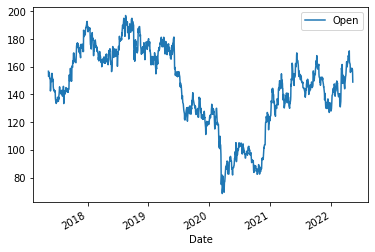

In [9]:
opn.plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
ds = opn.values

In [12]:
ds

array([[156.75004578],
       [153.00003052],
       [154.89378357],
       ...,
       [158.        ],
       [154.94999695],
       [148.94999695]])

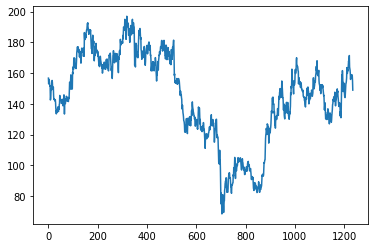

In [13]:
plt.plot(ds)

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [17]:
len(ds_scaled), len(ds)

(1236, 1236)

In [18]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [19]:
train_size,test_size

(865, 371)

In [20]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [21]:
len(ds_train),len(ds_test)

(865, 371)

In [22]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [23]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [24]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [25]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [26]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
12/12 [==============================] - 8s 239ms/step - loss: 0.1077 - val_loss: 0.0139
Epoch 2/20
12/12 [==============================] - 2s 129ms/step - loss: 0.0196 - val_loss: 0.0142
Epoch 3/20
12/12 [==============================] - 2s 132ms/step - loss: 0.0101 - val_loss: 0.0044
Epoch 4/20
12/12 [==============================] - 1s 118ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 5/20
12/12 [==============================] - 1s 118ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 6/20
12/12 [==============================] - 1s 117ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 7/20
12/12 [==============================] - 1s 122ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 8/20
12/12 [==============================] - 1s 122ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 9/20
12/12 [==============================] - 1s 121ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 10/20
12/12 [==============================] - 1s 117ms/step - loss: 0.0036 - val_loss: 0.0042

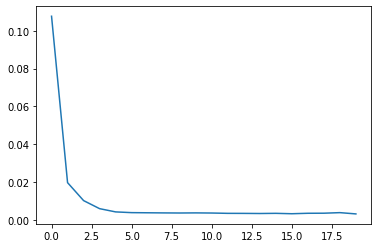

In [30]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [32]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

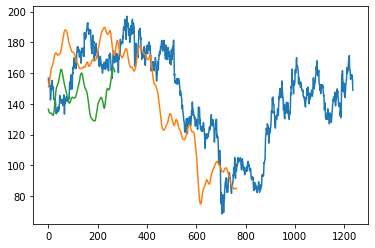

In [33]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [34]:
type(train_predict)

numpy.ndarray

In [35]:
test = np.vstack((train_predict,test_predict))

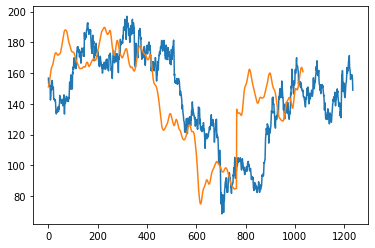

In [36]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [37]:
len(ds_test)

371

In [38]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [39]:
fut_inp = fut_inp.reshape(1,-1)

In [40]:
tmp_inp = list(fut_inp)

In [41]:
fut_inp.shape

(1, 101)

In [42]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [43]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7084294557571411], [0.7026345729827881], [0.6973105669021606], [0.6926491856575012], [0.6887019872665405], [0.6854282021522522], [0.6827349662780762], [0.6805086135864258], [0.6786354780197144], [0.6770142316818237], [0.6755614280700684], [0.6742132306098938], [0.6729233860969543], [0.6716604828834534], [0.6704054474830627], [0.669147253036499], [0.6678812503814697], [0.6666058301925659], [0.665321946144104], [0.6640312671661377], [0.6627355813980103], [0.6614367365837097], [0.6601362824440002], [0.6588348746299744], [0.6575331687927246], [0.6562315225601196], [0.6549299359321594], [0.6536282300949097], [0.6523261070251465], [0.6510232090950012]]


In [44]:
len(ds_scaled)

1236

In [45]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

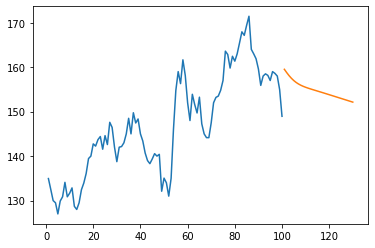

In [47]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1136:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [48]:
ds_new = ds_scaled.tolist()

In [49]:
len(ds_new)

1236

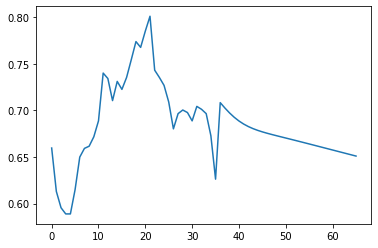

In [50]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [51]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

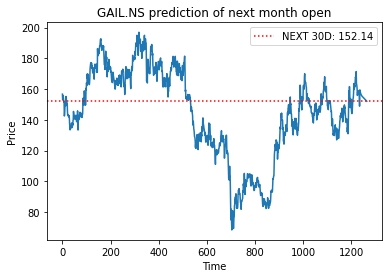

In [52]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

